In [ ]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
from pathlib import Path
root_path = Path.cwd().parent.absolute()
import sys
sys.path.append(str(root_path))
import os

In [ ]:
from architectures.architectures import MLP

from flax import nnx
import jax
from jax._src.tree_util import tree_structure
import jax.numpy as jnp
from jaxtyping import Array

In [ ]:
index = 3
device = jax.devices()[index] if jax.devices() else jax.devices('cpu')[0] # If only one gpu change index to 0
print(f"Selected device: {device}")

# NODE setup

In [ ]:
from architectures.node import NeuralODE

In [ ]:
key = jax.random.PRNGKey(0)
rngs = nnx.Rngs(key)
model = MLP(din=2, num_layers=3, width_layers=128, dout=2, activation_fn="tanh", rngs=nnx.Rngs(0))
node = NeuralODE(
    dynamics_model=model,
    time_dependent=False,
    dt0=0.1,
    rtol=1e-4,
    atol=1e-6
)

# Initial condition
y0 = jnp.array([1.0, 0.5])

# Solve from t=0 to t=1
y_final = node(y0, (0.0, 1.0))
print("Final state:", y_final)

# G Mat

In [ ]:
from geometry.G_matrix import G_matrix

In [ ]:
# G_mat = G_matrix(node)

In [ ]:
# # Test
# key = jax.random.PRNGKey(0)
# rngs = nnx.Rngs(key)

# n_samples = 100_000
# d = 2
# z_samples = jax.random.normal(key,(n_samples,d))

# z_samples = jax.device_put(z_samples,device)


In [ ]:
# _,params = nnx.split(node)
# key,subkey = jax.random.split(key)
# eta = jax.tree.map(lambda p:jax.random.normal(subkey, p.shape)*10, params) #   jax.numpy.ones(p.shape)
# eta = jax.tree.map(lambda p: jax.device_put(p,device), eta)
# key,subkey = jax.random.split(key)
# epsilon = jax.tree.map(lambda p: jax.random.normal(subkey, p.shape)*0.1, params)
# eta_pert = jax.tree.map(lambda e,ep: e+ep, eta, epsilon)

In [ ]:
# # Compute G_hat@eta
# result = G_mat.mvp(z_samples, eta)

In [ ]:
# key,subkey = jax.random.split(key)
# z_samples = jax.random.normal(subkey,(n_samples,d))
# z_samples = jax.device_put(z_samples,device)

# # Test solver 
# result_solver, _ = G_mat.solve_system(z_samples, result, tol=1e-6, maxiter=20,x0 = eta_pert, method="minres")

In [ ]:
# jax.tree.map(lambda x,y: jnp.linalg.norm(x-y)/jnp.linalg.norm(y), result_solver, eta)

In [ ]:
# verify_result = G_mat.mvp(z_samples, result_solver)
# jax.tree.leaves(jax.tree.map(lambda x,y: jnp.linalg.norm(x-y)/jnp.linalg.norm(y), result, verify_result))

# Gradient flow test

In [ ]:
@jax.jit
def quadratic_potential(x: Array) -> Array:
    """
    Evaluate quadratic potential U(x) = x^2 (sum over dimensions)
    Args:
        x: Array of shape (batch_size, d) - particle positions
    Returns:
        Array of shape (batch_size,) - potential values
    """
    return jnp.sum(x**2, axis=-1)


In [ ]:
from typing import Optional
from jaxtyping import PyTree,Array
from flax import nnx
import jax

In [ ]:
def compute_energy_gradient(node: nnx.Module, z_samples: Array, params: Optional[PyTree] = None) -> PyTree:
    """
    Compute gradient of energy functional F(ρ) = ∫ U(x)ρ(x)dx
    Args:
        node: Neural ODE model
        z_samples: Reference samples (batch_size, d)
        params: Parameters to evaluate gradient at (if None, uses current node params)
    Returns:
        Gradient ∇_θ F(θ)
    """
    if params is None:
        _, params = nnx.split(node)
    
    def energy_functional(p: PyTree) -> Array:
        # Transform reference samples through flow
        x_samples = node(z_samples, (0.0, 1.0), params=p)
        # Evaluate potential and average (Monte Carlo estimate)
        potential_values = quadratic_potential(x_samples)
        return jnp.mean(potential_values)
    
    return jax.grad(energy_functional)(params)

In [ ]:
def evaluate_energy(node: nnx.Module, z_samples: Array, params: Optional[PyTree] = None) -> Array:
    """
    Evaluate current energy F(ρ_θ)
    Args:
        node: Neural ODE model
        z_samples: Reference samples
        params: Parameters (if None, uses current node params)
    Returns:
        Energy value
    """
    if params is None:
        _, params = nnx.split(node)

    x_samples = node(z_samples, (0.0, 1.0), params=params)
    potential_values = quadratic_potential(x_samples)
    return jnp.mean(potential_values),x_samples

In [ ]:
# Cell 2: Initial Setup and Configuration

# Gradient flow parameters
h = 1e-1  # Time step size
max_iterations = 100
tolerance = 1e-6
n_samples = 20_000  # Monte Carlo sample size

# Initialize NODE with small parameters (near-identity pushforward)
key = jax.random.PRNGKey(42)
rngs = nnx.Rngs(key)

# Create NODE model
gradient_flow_model = MLP(din=2, num_layers=1, width_layers=32, dout=2, 
                         activation_fn="tanh", rngs=rngs)
gradient_flow_node = NeuralODE(
    dynamics_model=gradient_flow_model,
    time_dependent=False,
    dt0=0.1,
)

# Set parameters to be very small (near zero)
_, initial_params = nnx.split(gradient_flow_node)
scale_factor = 1e-2  # Small scaling to keep near identity

# Scale all parameters to be small
small_params = jax.tree.map(lambda p: p * scale_factor, initial_params)

# Merge back into the node
graphdef, _ = nnx.split(gradient_flow_node)
gradient_flow_node = nnx.merge(graphdef, small_params)

# Generate reference samples from λ = N(0, I)
key, subkey = jax.random.split(key)
z_samples = jax.random.normal(subkey, (n_samples, 2))

# Initialize tracking arrays
energy_history = []
solver_stats = []
param_norms = []

print(f"Initial setup complete:")
print(f"- Time step: {h}")
print(f"- Max iterations: {max_iterations}")
print(f"- Sample size: {n_samples}")
print(f"- Parameter scale factor: {scale_factor}")

# Verify initial energy (should be ~1.0 since E[x^2] for N(0,I) in 2D is 2.0)
_, current_params = nnx.split(gradient_flow_node)
initial_energy,push_samples = evaluate_energy(gradient_flow_node, z_samples, current_params)
print(f"- Initial energy: {initial_energy:.6f}")

energy_history.append(initial_energy)

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(push_samples[:,0], push_samples[:,1], alpha=0.1)

In [ ]:
# Quick alternative: try JAX's built-in CG with regularization
def solve_with_regularization(G_mat, z_samples, b, params, reg_param=1e-6):
    """
    Alternative solver using regularized CG
    """
    def regularized_matvec(eta):
        return jax.tree.map(lambda x, y: x + reg_param * y, 
                           G_mat.mvp(z_samples, eta, params), eta)
    
    from jax.scipy.sparse.linalg import cg
    return cg(regularized_matvec, b, tol=1e-6, maxiter=100)

In [ ]:

def gradient_flow_step(node: nnx.Module, z_samples: Array, G_mat: G_matrix, 
                      step_size: float = 0.01, solver_tol: float = 1e-6, 
                      solver_maxiter: int = 10) -> tuple[nnx.Module, dict]:
    """
    Perform one gradient flow step: θ^{k+1} = θ^k + h * η
    where G(θ^k) η = -∇_θ F(θ^k)
    
    Args:
        node: Current Neural ODE model
        z_samples: Reference samples for Monte Carlo estimation
        G_mat: G-matrix object for linear system solving
        step_size: Gradient flow step size h
        solver_tol: Tolerance for G-matrix linear solver
        solver_maxiter: Maximum iterations for linear solver
        
    Returns:
        updated_node: Node with updated parameters
        step_info: Dictionary with step diagnostics
    """
    
    # Get current parameters
    _, current_params = nnx.split(node)
    
    # Compute energy gradient ∇_θ F(θ)
    energy_grad = compute_energy_gradient(node, z_samples, current_params)
    # print(energy_grad)
    # Solve linear system: G(θ) η = -∇_θ F(θ)
    neg_energy_grad = jax.tree.map(lambda x: -x, energy_grad)
    eta, solver_info = G_mat.solve_system(z_samples, neg_energy_grad, 
                                         params=current_params,
                                         tol=solver_tol, 
                                         maxiter=solver_maxiter,
                                         method="minres")
    # def regularized_matvec(eta):
    #     return jax.tree.map(lambda x, y: x + 1e-6 * y, 
    #                    G_mat.mvp(z_samples, eta, current_params), eta)

    # eta, solver_info = jax.scipy.sparse.linalg.cg(regularized_matvec, neg_energy_grad, tol=1e-6, maxiter=100)
    # print(solver_info)
    # print(eta)
    # Update parameters: θ^{k+1} = θ^k + h * η
    updated_params = jax.tree.map(lambda p, e: p + step_size * e, current_params, eta)
    
    # Create updated node
    graphdef, _ = nnx.split(node)
    updated_node = nnx.merge(graphdef, updated_params)
    
    # Compute diagnostics
    grad_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(lambda x: jnp.sum(x**2), energy_grad))))
    eta_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(lambda x: jnp.sum(x**2), eta))))
    param_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(lambda x: jnp.sum(x**2), updated_params))))
    
    step_info = {
        # 'solver_success': solver_info['success'],
        # 'solver_iterations': solver_info['iterations'],
        # 'solver_residual': solver_info['norm_res'],
        'gradient_norm': grad_norm,
        'eta_norm': eta_norm,
        'param_norm': param_norm,
        'step_size': step_size
    }
    
    return updated_node, step_info




In [ ]:

print("Testing single gradient flow step...")

# Initialize G-matrix for gradient flow
G_mat_flow = G_matrix(gradient_flow_node)

# Store initial state
_, initial_params = nnx.split(gradient_flow_node)
initial_energy,initial_samples = evaluate_energy(gradient_flow_node, z_samples, initial_params)

# Perform one gradient flow step
updated_node, step_info = gradient_flow_step(gradient_flow_node, z_samples, G_mat_flow, 
                                           step_size=h, solver_tol=tolerance)

# Compute energy after step
_, updated_params = nnx.split(updated_node)
final_energy,final_samples = evaluate_energy(updated_node, z_samples, updated_params)

# Verification checks
energy_decrease = initial_energy - final_energy
relative_decrease = energy_decrease / initial_energy

print(f"\n=== Step Verification Results ===")
print(f"Initial energy:     {initial_energy:.6f}")
print(f"Final energy:       {final_energy:.6f}")
print(f"Energy decrease:    {energy_decrease:.6f}")
print(f"Relative decrease:  {relative_decrease:.4%}")
# print(f"Solver success:     {step_info['solver_success']}")
# print(f"Solver iterations:  {step_info['solver_iterations']}")
# print(f"Solver residual:    {step_info['solver_residual']:.2e}")
print(f"Gradient norm:      {step_info['gradient_norm']:.6f}")
print(f"Update norm:        {step_info['eta_norm']:.6f}")

# Validation
assert energy_decrease > 0, f"Energy should decrease! Got decrease: {energy_decrease}"
# assert step_info['solver_success'], "Linear solver should converge!"
# assert step_info['solver_residual'] < tolerance * 10, "Solver residual too large!"

print(f"\n✓ All checks passed! Gradient flow step working correctly.")

In [ ]:
fig = plt.figure(figsize=(20,15))
plt.scatter(initial_samples[:,0],initial_samples[:,1], alpha=0.5,s = 20)
plt.scatter(final_samples[:,0],final_samples[:,1], alpha=0.3,s = 10, c = 'r')

In [ ]:
print("Starting gradient flow integration...")

# Reset to initial state
graphdef, _ = nnx.split(gradient_flow_node)
gradient_flow_node = nnx.merge(graphdef, small_params)

# Clear tracking arrays
energy_history = []
solver_stats = []
param_norms = []

# Initial energy
_, current_params = nnx.split(gradient_flow_node)
current_energy,samples_prev = evaluate_energy(gradient_flow_node, z_samples, current_params)
energy_history.append(current_energy)

print(f"Initial energy: {current_energy:.6f}")
print(f"Target: converge to origin (energy → 0)")

key,subkey= jax.random.split(key)
z_samples_fixed = jax.random.normal(subkey, (n_samples, 2))
z_samples_fixed = jax.device_put(z_samples_fixed,device)
# Main integration loop
for iteration in range(max_iterations):

    key,subkey= jax.random.split(key)
    z_samples = jax.random.normal(subkey,(n_samples,2))
    
    # Perform gradient flow step
    gradient_flow_node, step_info = gradient_flow_step(gradient_flow_node, z_samples, G_mat_flow,
                                                      step_size=h, solver_tol=tolerance)
    # Evaluate new energy
    _, current_params = nnx.split(gradient_flow_node)
    current_energy,samples_next = evaluate_energy(gradient_flow_node, z_samples_fixed, current_params)
    
    # Store diagnostics
    energy_history.append(current_energy)
    solver_stats.append(step_info)
    param_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(lambda x: jnp.sum(x**2), current_params))))
    param_norms.append(param_norm)
    
    # Progress reporting
    if iteration % 10 == 0 :
        energy_decrease = energy_history[0] - current_energy
        mean_samples = jnp.mean(samples_next,axis=0)
        cov_mat = jnp.cov(samples_next.T)
        print(f"Iter {iteration:3d}: Energy = {current_energy:.6f}, "
              f"Decrease = {energy_decrease:.6f}")
        print(f"Mean samples: {mean_samples}")
        print(f"Covariance matrix:\n{cov_mat}")
        fig = plt.figure(figsize=(20,15))
        plt.scatter(samples_prev[:,0], samples_prev[:,1], s = 10, alpha = 0.5,label = "Previous Samples")
        plt.scatter(samples_next[:,0], samples_next[:,1], s = 10, alpha = 0.3,label = "Current Samples")
        plt.title(f"Samples at step {iteration}")
        plt.grid(visible = True)
        plt.xlim(-4.0,4.0)
        plt.ylim(-4.0,4.0)
        plt.legend()
        plt.show()
    samples_prev = samples_next
    # Early stopping conditions
    if current_energy < tolerance:
        print(f"✓ Converged! Energy below tolerance at iteration {iteration}")
        break
        
    # if iteration > 5 and abs(energy_history[-1] - energy_history[-2]) < tolerance * 1e-2:
    #     print(f"✓ Energy converged at iteration {iteration}")
    #     break

# Final summary
final_energy = energy_history[-1]
total_decrease = energy_history[0] - final_energy

print(f"\n=== Integration Complete ===")
print(f"Total iterations:    {len(energy_history)-1}")
print(f"Initial energy:      {energy_history[0]:.6f}")
print(f"Final energy:        {final_energy:.6f}")
print(f"Total decrease:      {total_decrease:.6f}")
print(f"Reduction ratio:     {final_energy/energy_history[0]:.4f}")
print(f"Final param norm:    {param_norms[-1]:.6f}")

# General form

In [ ]:
from typing import Callable, Optional, Any
from jaxtyping import PyTree, Array
import jax
import jax.numpy as jnp
from flax import nnx

class LinearPotential(nnx.Module):
    """
    A class for handling linear potential energy functionals F(ρ) = ∫ U(x)ρ(x)dx
    where U(x) is a user-defined potential function.
    """
    
    def __init__(self, potential_fn: Callable[[Array], Array], **potential_kwargs):
        """
        Initialize LinearPotential with a potential function.
        
        Args:
            potential_fn: Function that takes positions (batch_size, d) and returns 
                         potential values (batch_size,)
            **potential_kwargs: Additional keyword arguments for the potential function
        """
        self.potential_fn = potential_fn
        self.potential_kwargs = potential_kwargs
    
    def __call__(self, x: Array) -> Array:
        """
        Evaluate potential at given positions.
        
        Args:
            x: Positions array of shape (batch_size, d)
        Returns:
            Potential values of shape (batch_size,)
        """
        return self.potential_fn(x, **self.potential_kwargs)
    
    def compute_energy_gradient(self, node: nnx.Module, z_samples: Array, 
                               params: Optional[PyTree] = None) -> PyTree:
        """
        Compute gradient of energy functional F(ρ) = ∫ U(x)ρ(x)dx
        
        Args:
            node: Neural ODE model
            z_samples: Reference samples (batch_size, d)
            params: Parameters to evaluate gradient at (if None, uses current node params)
        Returns:
            Gradient ∇_θ F(θ)
        """
        if params is None:
            _, params = nnx.split(node)
        
        def energy_functional(p: PyTree) -> Array:
            # Transform reference samples through flow
            x_samples = node(z_samples, (0.0, 1.0), params=p)
            # Evaluate potential and average (Monte Carlo estimate)
            potential_values = self.potential_fn(x_samples, **self.potential_kwargs)
            return jnp.mean(potential_values)
        
        return jax.grad(energy_functional)(params)
    
    def evaluate_energy(self, node: nnx.Module, z_samples: Array,
                       params: Optional[PyTree] = None) -> tuple[Array, Array]:
        """
        Evaluate current energy F(ρ_θ)
        
        Args:
            node: Neural ODE model
            z_samples: Reference samples
            params: Parameters (if None, uses current node params)
        Returns:
            (energy_value, transformed_samples)
        """
        if params is None:
            _, params = nnx.split(node)

        x_samples = node(z_samples, (0.0, 1.0), params=params)
        potential_values = self.potential_fn(x_samples, **self.potential_kwargs)
        return jnp.mean(potential_values), x_samples

# Define specific potential functions
@jax.jit
def quadratic_potential_fn(x: Array) -> Array:
    """
    Quadratic potential U(x) = |x|²/2
    """
    return jnp.sum(x**2, axis=-1) / 2.0

@jax.jit  
def double_well_potential_fn(x: Array, alpha: float = 1.0) -> Array:
    """
    Double-well potential U(x,y) = (y² - 1)² + α*x²
    """
    x_coord = x[:, 0]  # x-coordinates
    y_coord = x[:, 1]  # y-coordinates
    
    # Double-well in y: (y² - 1)²
    y_term = (y_coord**2 - 1.0)**2
    
    # Harmonic confinement in x: αx²
    x_term = alpha * x_coord**2
    
    return y_term + x_term

@jax.jit
def quartic_potential_fn(x: Array, strength: float = 0.1) -> Array:
    """
    Quartic potential U(x) = strength * |x|⁴ + 0.5 * |x|²
    """
    r_squared = jnp.sum(x**2, axis=-1)
    return strength * r_squared**2 + 0.5 * r_squared

# Usage examples:

# Create different potential instances
def create_potentials():
    """Factory function to create common potential instances"""
    
    # Quadratic potential (particles move to origin)
    quadratic_potential = LinearPotential(quadratic_potential_fn)
    
    # Double-well potential (particles move to [0,±1])
    double_well_potential = LinearPotential(double_well_potential_fn, alpha=1.0)
    
    # Strong double-well potential (narrower wells)
    strong_double_well = LinearPotential(double_well_potential_fn, alpha=5.0)
    
    # Quartic potential (softer confinement)
    quartic_potential = LinearPotential(quartic_potential_fn, strength=0.1)
    
    return {
        'quadratic': quadratic_potential,
        'double_well': double_well_potential, 
        'strong_double_well': strong_double_well,
        'quartic': quartic_potential
    }

def gradient_flow_step_with_potential(node: nnx.Module, z_samples: Array, G_mat: G_matrix,
                                    potential: LinearPotential, step_size: float = 0.01,
                                    solver_tol: float = 1e-6, solver_maxiter: int = 50,
                                    use_regularization: bool = True) -> tuple[nnx.Module, dict]:
    """
    Generic gradient flow step that works with any LinearPotential
    
    Args:
        node: Current Neural ODE model
        z_samples: Reference samples for Monte Carlo estimation
        G_mat: G-matrix object for linear system solving
        potential: LinearPotential instance
        step_size: Gradient flow step size h
        solver_tol: Tolerance for linear solver
        solver_maxiter: Maximum iterations for linear solver
        use_regularization: Whether to use regularized CG solver
        
    Returns:
        updated_node: Node with updated parameters
        step_info: Dictionary with step diagnostics
    """
    
    # Get current parameters
    _, current_params = nnx.split(node)
    
    # Compute energy gradient using the potential
    energy_grad = potential.compute_energy_gradient(node, z_samples, current_params)
    
    # Solve linear system: G(θ) η = -∇_θ F(θ)
    neg_energy_grad = jax.tree.map(lambda x: -x, energy_grad)
    
    if use_regularization:
        # Use regularized CG solver
        def regularized_matvec(eta):
            return jax.tree.map(lambda x, y: x + 1e-6 * y, 
                               G_mat.mvp(z_samples, eta, current_params), eta)
        
        from jax.scipy.sparse.linalg import cg
        eta, solver_info_raw = cg(regularized_matvec, neg_energy_grad, 
                                 tol=solver_tol, maxiter=solver_maxiter)
        
        # solver_info = {
        #     'success': solver_info_raw.info == 0,
        #     'iterations': solver_info_raw.nit,
        #     'norm_res': solver_info_raw.info
        # }
    else:
        # Use MINRES solver
        eta, solver_info = G_mat.solve_system(z_samples, neg_energy_grad,
                                             params=current_params,
                                             tol=solver_tol, 
                                             maxiter=solver_maxiter,
                                             method="minres")
    
    # Update parameters: θ^{k+1} = θ^k + h * η
    updated_params = jax.tree.map(lambda p, e: p + step_size * e, current_params, eta)
    
    # Create updated node
    graphdef, _ = nnx.split(node)
    updated_node = nnx.merge(graphdef, updated_params)
    
    # Compute diagnostics
    grad_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(lambda x: jnp.sum(x**2), energy_grad))))
    eta_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(lambda x: jnp.sum(x**2), eta))))
    param_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(lambda x: jnp.sum(x**2), updated_params))))
    
    step_info.update({
        'gradient_norm': grad_norm,
        'eta_norm': eta_norm,
        'param_norm': param_norm,
        'step_size': step_size
    })
    
    return updated_node, step_info

In [121]:
# Gradient Flow Integration with LinearPotential

def run_gradient_flow(node: nnx.Module, z_samples: Array, G_mat: G_matrix,
                     potential: LinearPotential, h: float = 0.01, 
                     max_iterations: int = 100, tolerance: float = 1e-6,
                     use_regularization: bool = True, 
                     progress_every: int = 10) -> dict:
    """
    Run complete gradient flow integration with any LinearPotential
    
    Args:
        node: Initial Neural ODE model
        z_samples: Reference samples for Monte Carlo estimation
        G_mat: G-matrix object for linear system solving
        potential: LinearPotential instance defining the energy functional
        h: Time step size
        max_iterations: Maximum number of gradient flow steps
        tolerance: Convergence tolerance for energy
        use_regularization: Whether to use regularized CG solver
        progress_every: Print progress every N iterations
        
    Returns:
        results: Dictionary containing energy history, solver stats, etc.
    """
    
    print(f"Starting gradient flow with {potential.__class__.__name__}...")
    print(f"Potential function: {potential.potential_fn.__name__}")
    print(f"Potential parameters: {potential.potential_kwargs}")
    
    # Initialize tracking
    energy_history = []
    solver_stats = []
    param_norms = []
    sample_history = []  # Store samples at key iterations for visualization
    
    # Initial state
    _, current_params = nnx.split(node)
    current_energy, current_samples = potential.evaluate_energy(node, z_samples, current_params)
    energy_history.append(float(current_energy))
    sample_history.append(current_samples)
    
    print(f"Initial energy: {current_energy:.6f}")
    print(f"Target: minimize energy functional")
    
    # Main integration loop
    current_node = node

    #Initialize key for sample generation
    key = jax.random.PRNGKey(0)
    n_samples = len(z_samples)
    
    for iteration in range(max_iterations):
        
        key,subkey= jax.random.split(key)
        z_samples_eval = jax.random.normal(subkey,(n_samples,2))
        z_samples_eval = jax.device_put(z_samples_eval,device)
        # Perform gradient flow step
        current_node, step_info = gradient_flow_step_with_potential(
            current_node, z_samples_eval, G_mat, potential,
            step_size=h, 
            solver_tol=tolerance,
            use_regularization=use_regularization
        )
        
        # Evaluate new energy
        _, current_params = nnx.split(current_node)
        current_energy, current_samples = potential.evaluate_energy(current_node, z_samples, current_params)
        
        # Store diagnostics
        energy_history.append(float(current_energy))
        solver_stats.append(step_info)
        param_norm = jnp.sqrt(sum(jax.tree.leaves(jax.tree.map(lambda x: jnp.sum(x**2), current_params))))
        param_norms.append(float(param_norm))
        
        # Store samples for visualization at regular intervals
        if iteration % progress_every == 0 or iteration == max_iterations - 1:
            sample_history.append(current_samples)
        
        # Progress reporting
        if iteration % progress_every == 0 :
            energy_decrease = energy_history[0] - current_energy
            print(f"Iter {iteration:3d}: Energy = {current_energy:.6f}, "
                  f"Decrease = {energy_decrease:.6f}, "
                  f"Grad norm: {step_info['gradient_norm']:.2e}")
            plt.scatter(current_samples[:,0], current_samples[:,1], s = 10, alpha = 0.3)
            plt.show()
        
        # Early stopping conditions
        if current_energy < tolerance:
            print(f"✓ Converged! Energy below tolerance at iteration {iteration}")
            break
            
                    
        if iteration > 5 and abs(energy_history[-1] - energy_history[-2]) < tolerance * 1e-2:
            print(f"✓ Energy converged at iteration {iteration}")
            break
    
    # Final summary
    final_energy = energy_history[-1]
    total_decrease = energy_history[0] - final_energy
    
    print(f"\n=== Integration Complete ===")
    print(f"Total iterations:    {len(energy_history)-1}")
    print(f"Initial energy:      {energy_history[0]:.6f}")
    print(f"Final energy:        {final_energy:.6f}")
    print(f"Total decrease:      {total_decrease:.6f}")
    print(f"Reduction ratio:     {final_energy/energy_history[0]:.4f}")
    print(f"Final param norm:    {param_norms[-1]:.6f}")
    
    return {
        'final_node': current_node,
        'energy_history': energy_history,
        'param_norms': param_norms,
        'sample_history': sample_history,
        'potential': potential,
        'convergence_info': {
            'converged': final_energy < tolerance or abs(energy_history[-1] - energy_history[-2]) < tolerance * 1e-2,
            'final_energy': final_energy,
            'total_decrease': total_decrease,
            'iterations': len(energy_history) - 1
        }
    }

def visualize_gradient_flow_results(results: dict, figsize: tuple = (15, 10)):
    """
    Visualize the gradient flow results
    
    Args:
        results: Results dictionary from run_gradient_flow
        figsize: Figure size for plots
    """
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Energy decay plot
    axes[0,0].plot(results['energy_history'])
    axes[0,0].set_xlabel('Iteration')
    axes[0,0].set_ylabel('Energy')
    axes[0,0].set_title('Energy Decay')
    axes[0,0].grid(True)
    axes[0,0].set_yscale('log')
    
    # Parameter norm evolution
    axes[0,1].plot(results['param_norms'])
    axes[0,1].set_xlabel('Iteration') 
    axes[0,1].set_ylabel('Parameter Norm')
    axes[0,1].set_title('Parameter Evolution')
    axes[0,1].grid(True)
    
    # Initial vs Final samples
    initial_samples = results['sample_history'][0]
    final_samples = results['sample_history'][-1]
    
    axes[1,0].scatter(initial_samples[:,0], initial_samples[:,1], alpha=0.5, s=1, label='Initial')
    axes[1,0].set_xlabel('x')
    axes[1,0].set_ylabel('y')
    axes[1,0].set_title('Initial Distribution')
    axes[1,0].legend()
    axes[1,0].grid(True)
    axes[1,0].set_aspect('equal')
    
    axes[1,1].scatter(final_samples[:,0], final_samples[:,1], alpha=0.5, s=1, c='red', label='Final')
    axes[1,1].set_xlabel('x')
    axes[1,1].set_ylabel('y') 
    axes[1,1].set_title('Final Distribution')
    axes[1,1].legend()
    axes[1,1].grid(True)
    axes[1,1].set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

# Example usage for different potentials
def test_gradient_flows():
    """
    Test gradient flow with different potentials
    """
    
    # Setup (assuming you have these from previous cells)
    # node, z_samples, G_mat_flow should be defined
    
    # Create potentials
    potentials = create_potentials()
    
    # Test 1: Quadratic potential
    print("="*50)
    print("TESTING QUADRATIC POTENTIAL")
    print("="*50)
    
    quadratic_results = run_gradient_flow(
        gradient_flow_node, z_samples, G_mat_flow,
        potentials['quadratic'],
        h=0.1, max_iterations=50, tolerance=1e-6
    )
    
    # Test 2: Double-well potential  
    print("\n" + "="*50)
    print("TESTING DOUBLE-WELL POTENTIAL")
    print("="*50)
    
    double_well_results = run_gradient_flow(
        gradient_flow_node, z_samples, G_mat_flow, 
        potentials['double_well'],
        h=0.05, max_iterations=100, tolerance=1e-6
    )
    
    # Visualize results
    print("\nVisualizing quadratic potential results...")
    visualize_gradient_flow_results(quadratic_results)
    
    print("\nVisualizing double-well potential results...")
    visualize_gradient_flow_results(double_well_results)
    
    return quadratic_results, double_well_results

In [68]:
# Create potentials
potentials = create_potentials()

In [124]:
# Create NODE model
gradient_flow_model = MLP(din=2, num_layers=1, width_layers=32, dout=2, 
                         activation_fn="tanh", rngs=rngs)
gradient_flow_node = NeuralODE(
    dynamics_model=gradient_flow_model,
    time_dependent=False,
    dt0=0.1,
)

Starting gradient flow with LinearPotential...
Potential function: quadratic_potential_fn
Potential parameters: {}
Initial energy: 1.807193
Target: minimize energy functional
Iter   0: Energy = 1.447233, Decrease = 0.359960, Grad norm: 3.00e+00


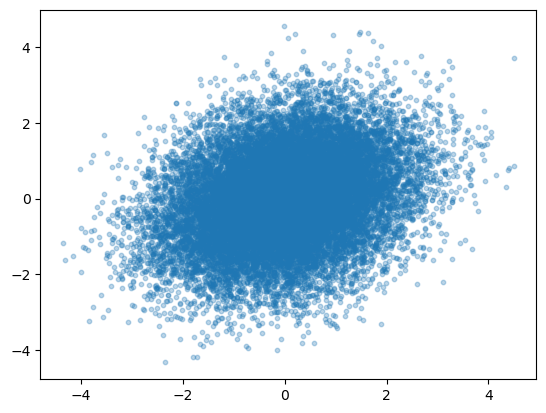

Iter  10: Energy = 0.159359, Decrease = 1.647834, Grad norm: 4.48e-01


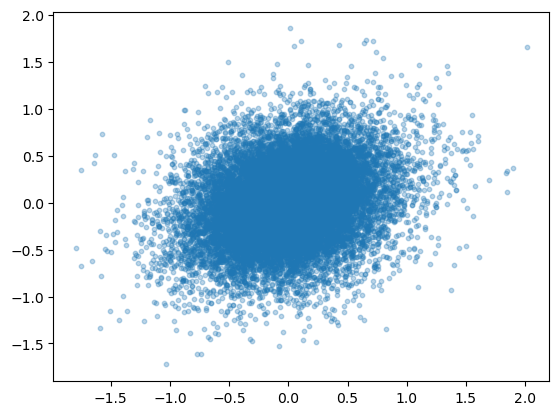

Iter  20: Energy = 0.018219, Decrease = 1.788974, Grad norm: 7.16e-02


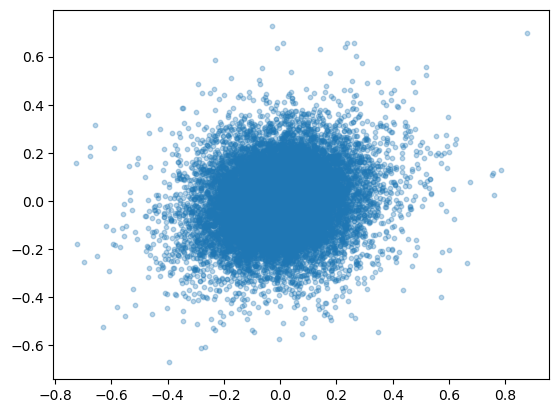

Iter  30: Energy = 0.002020, Decrease = 1.805173, Grad norm: 9.61e-03


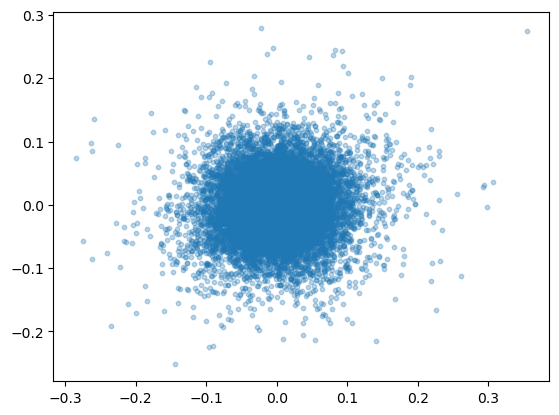

Iter  40: Energy = 0.001561, Decrease = 1.805632, Grad norm: 8.97e-03


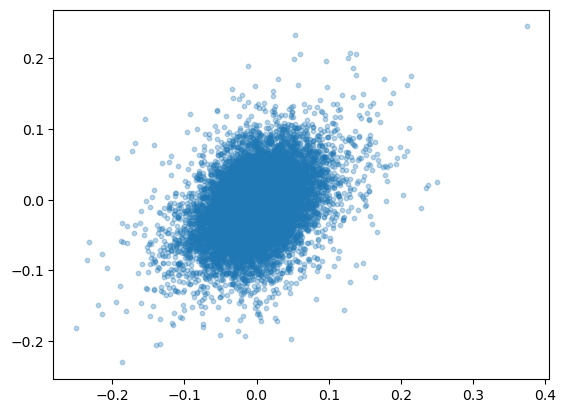


=== Integration Complete ===
Total iterations:    50
Initial energy:      1.807193
Final energy:        0.001238
Total decrease:      1.805955
Reduction ratio:     0.0007
Final param norm:    3.772672


In [125]:
# Test quadratic potential (should converge to origin)
quadratic_results = run_gradient_flow(
    gradient_flow_node, z_samples, G_mat_flow,
    potentials['quadratic'],
    use_regularization=False,
    h=0.1, max_iterations=50
)

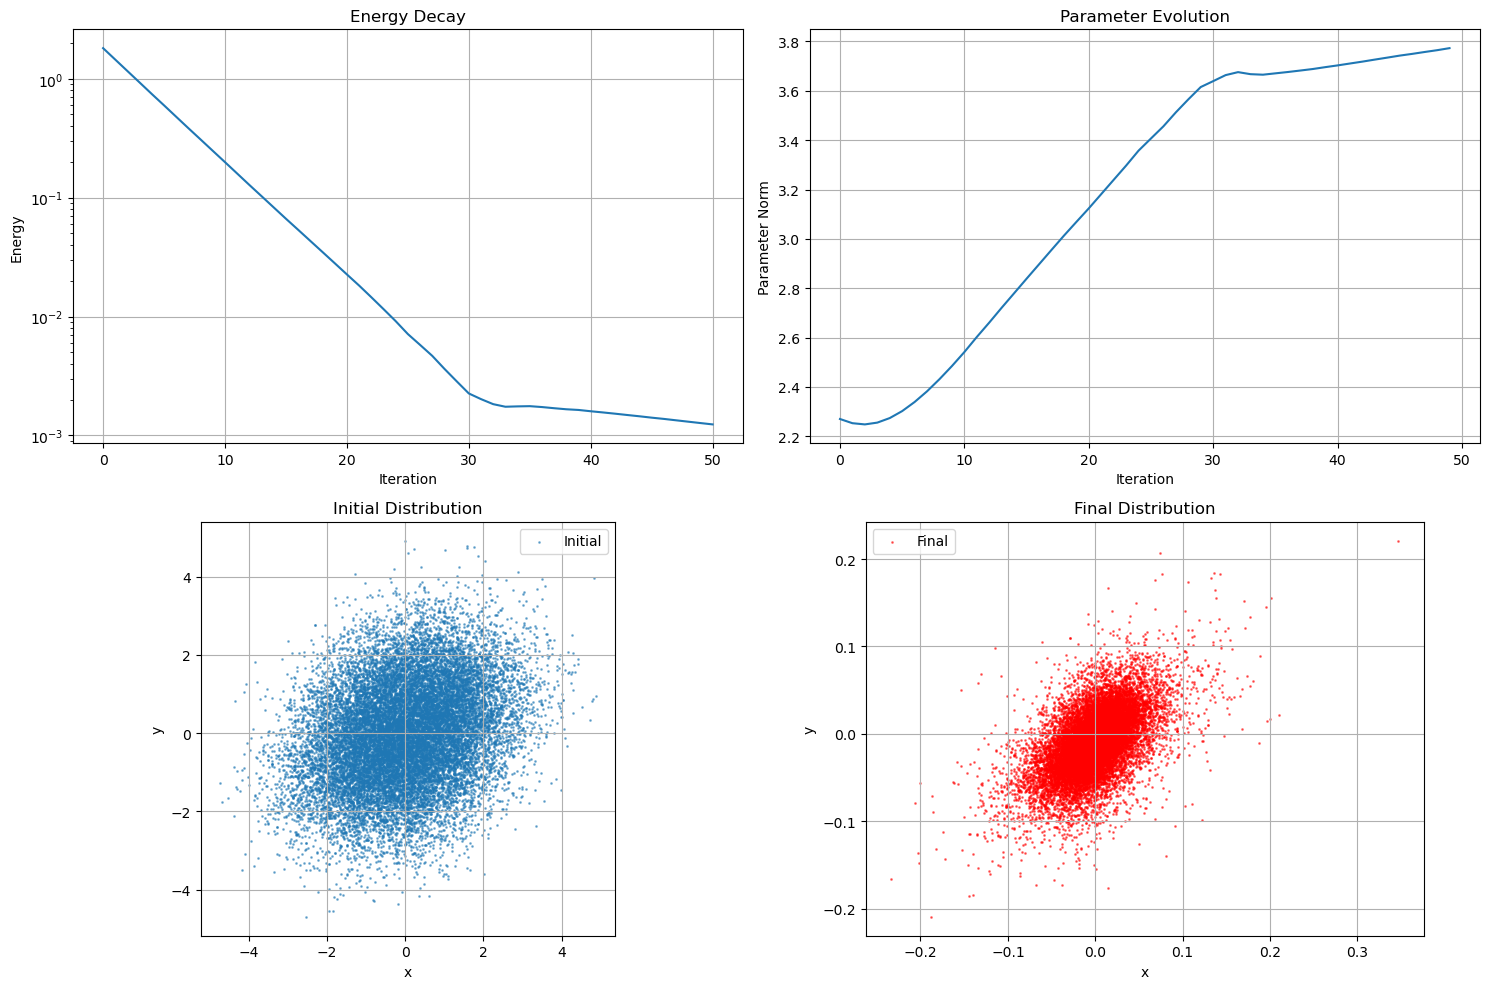

In [126]:
# Visualize results
visualize_gradient_flow_results(quadratic_results)

In [134]:
# Create NODE model
gradient_flow_model = MLP(din=2, num_layers=1, width_layers=32, dout=2, 
                         activation_fn="tanh", rngs=rngs)
gradient_flow_node = NeuralODE(
    dynamics_model=gradient_flow_model,
    time_dependent=False,
    dt0=0.1,
)

Starting gradient flow with LinearPotential...
Potential function: double_well_potential_fn
Potential parameters: {'alpha': 1.0}
Initial energy: 4.383915
Target: minimize energy functional
Iter   0: Energy = 1.377250, Decrease = 3.006665, Grad norm: 1.68e+01


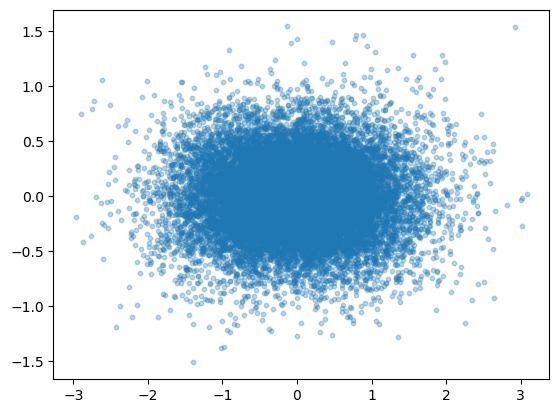

Iter  10: Energy = 0.696958, Decrease = 3.686956, Grad norm: 1.03e-01


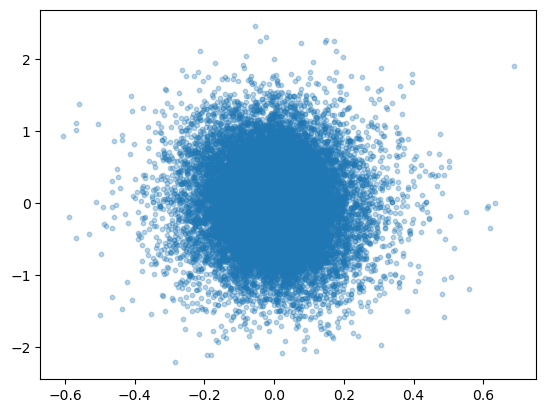

Iter  20: Energy = 0.680914, Decrease = 3.703001, Grad norm: 4.23e-02


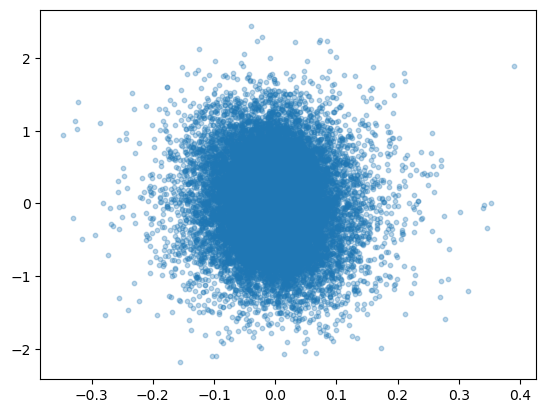

Iter  30: Energy = 0.675977, Decrease = 3.707938, Grad norm: 5.24e-02


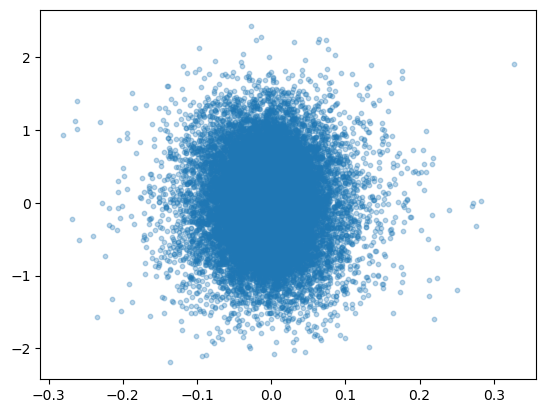

Iter  40: Energy = 0.669131, Decrease = 3.714784, Grad norm: 5.55e-02


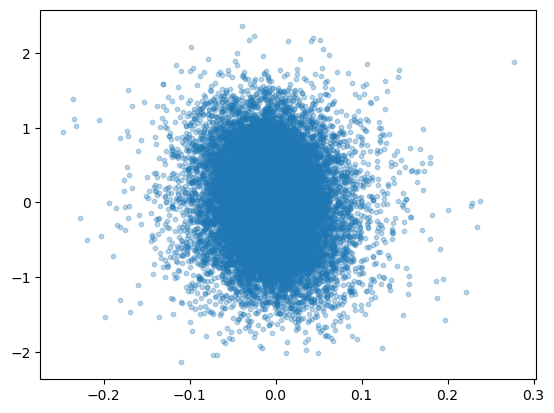


=== Integration Complete ===
Total iterations:    50
Initial energy:      4.383915
Final energy:        0.656492
Total decrease:      3.727422
Reduction ratio:     0.1498
Final param norm:    3.216794


In [135]:
# Test double-well potential (should split into two modes)
double_well_results = run_gradient_flow(
    gradient_flow_node, z_samples, G_mat_flow,
    potentials['double_well'], 
    use_regularization=False,
    h=0.1, max_iterations=50
)

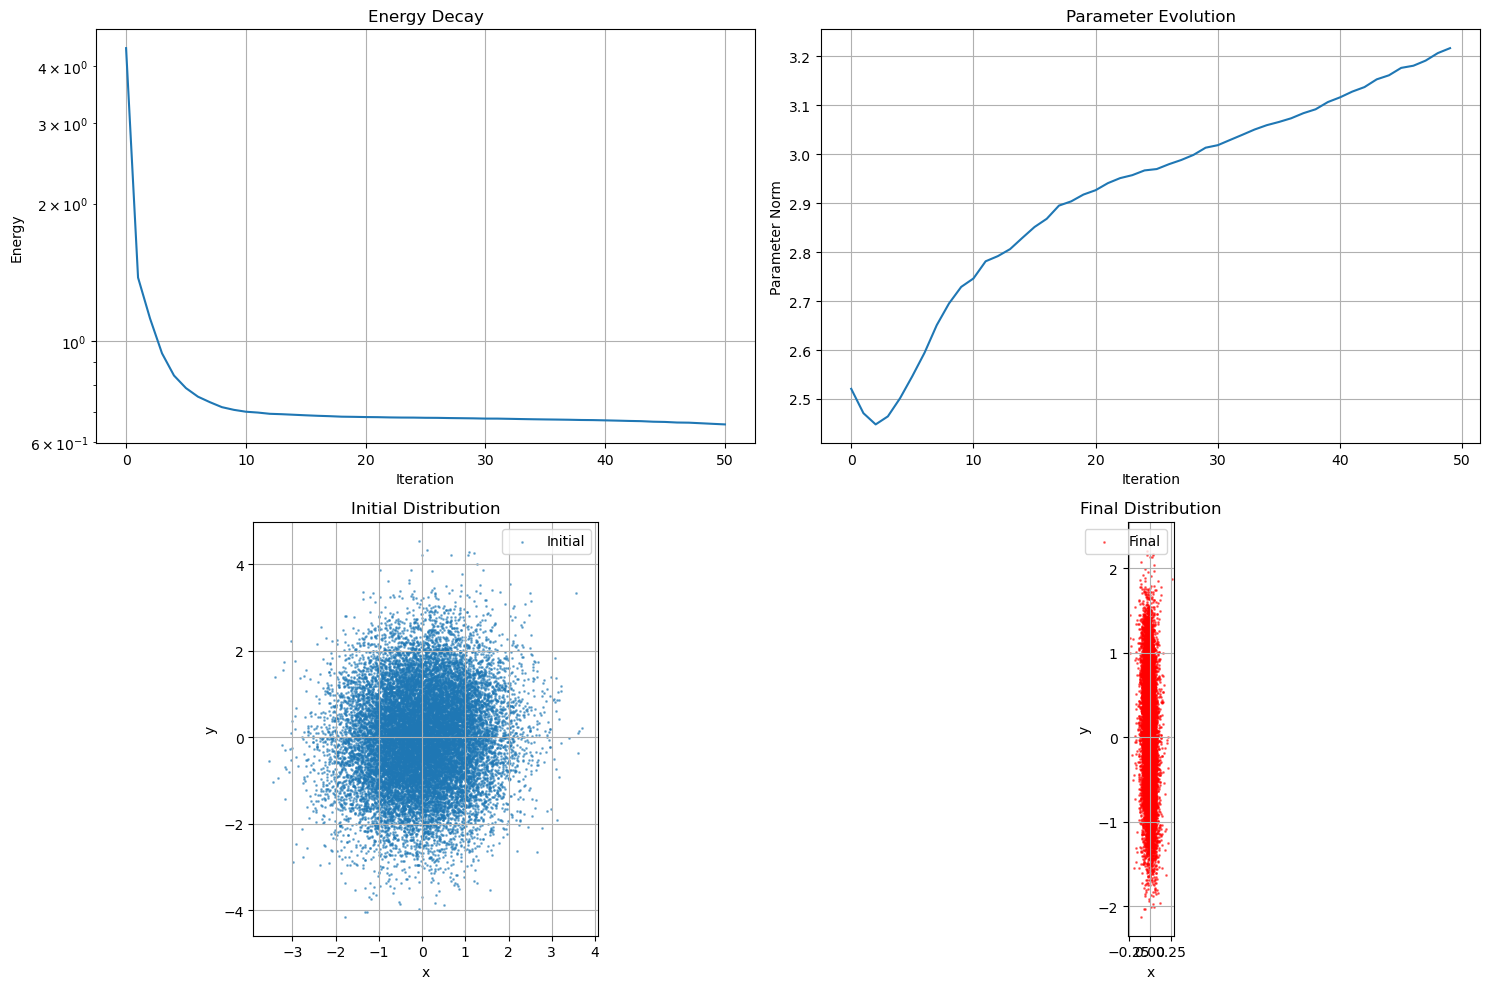

In [136]:
# Visualize results
visualize_gradient_flow_results(double_well_results)

(100, 100) (100, 100)


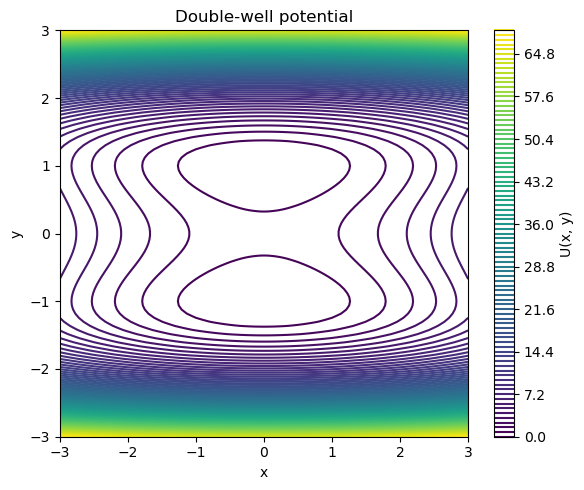

In [120]:
x,y = jnp.linspace(-3, 3, 100), jnp.linspace(-3, 3, 100)
X,Y = jnp.meshgrid(x,y)
print(X.shape,Y.shape)
X = X.reshape(-1)
Y = Y.reshape(-1)
cat = jnp.concatenate([X[..., None], Y[..., None]], axis=-1)
Z = double_well_potential_fn(cat, alpha=.5)

# Reshape back to 2D grids for contouring
X = X.reshape(100,100)
Y = Y.reshape(100,100)
Z = Z.reshape(100,100)

plt.figure(figsize=(6,5))
cf = plt.contour(X, Y, Z, levels=100, cmap='viridis')
plt.colorbar(cf, label='U(x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Double-well potential')
plt.tight_layout()
plt.show()